# Week 2


In the end of week 1 meeting we figured out the problems I had with entering the arrays to create an average, teaching me some very useful techniques which will be useful later in the project when we look to implement the shifted data sets as well as in other projects later on.

Objectives for week 2:

    1.Untangle and annotate confusing week 1 code.
    2.Experiment with alternative average functions.
    3.Find a better reigon for weighted average.
    4.Try to understand how to shift a spectrum and how much the spectrum should be shifted by.

Copied over all essential code from week 1.

In [1]:
import numpy as np
import json, sys, os

import matplotlib.pyplot as plt
from matplotlib import rc, cm

# Get the path of the current directory
path = os.getcwd()
home = os.path.dirname(path)

# Print the repository home directory
print("Repository home directory:",home)

# Add the src folder to the system path
sys.path.append(home+'/src')

# Import the python functions stored in the src folder
from calculations import Calc, Model, Stats

# We shorten the functions name to make it easier to call the required a functions
## 3 functions from P.Strom written code
c   = Calc()
m   = Model()
s   = Stats()

# Importing parameters from a json file.
# You can use this file to edit parameters later.

## Editing the paramenters in a file proves easier than writing it into the code 
with open(home+'/params.json') as param_file:    
   param = json.load(param_file)

# We read in the data directories we are using. To see what directories this is open params.json.
datadirs = param["datadirs"]

# Choose what part of the spectrum you wan to look at
# B is the blue end, whilst A is the red end)
part     = param["BetaPictoris"]["part"]

Repository home directory: C:\Users\Oliver\Documents\urss


In [2]:
# Load the data into the multidimentional array D
if param["filenames"]["split_files"] == "yes":
    D = c.LoadData(home+'/data/D_'+part+'_split.npz')
else:
    D = c.LoadData(home+'/data/D_'+part+'.npz')

The following is the main target for objectives 1,2 and 3, it is the code from end of week 1 meeting used to average the data and plot a single collated spectrum. 

In [3]:
#Allow us to explore the graph in real time (pan, zoom etc).
#%matplotlib widget (the # just to prevent lag when loading every time - I did fix and use this week)

# Creating empty lists for our Flux, Error in Flux, corrected flux values 
d0 = [] # Flux
e0 = [] # Error
d0_n = [] # Corrected flux values

# Extracting the Flux and Flux Error data for each observation and putting them into d0 and e0
for i in range(len(D)): # For each visit (repeat for all 13 data collections)
    for j in range(len(D[i])): # Within each visit (cycle over number of orbits)
        if j == 0: # If orbit == 0 (for the first orbit only - as we are interested in unshifted data)
            d0.append(D[i][j][1][5000:15000]) # Add to d0 the y values (Flux)
            e0.append(D[i][j][2][5000:15000]) # Add to e0 the y error values (Error in Flux)

            
# Converting lists into numpy arrays (allowing for easier manipulation later on with averaging functions)
d0 = np.array(d0)
e0 = np.array(e0)
w = D[0][0][0][5000:15000] # Defining w as the width of the spectra (more simple for plotting and can easily apply boundaries) 



# Normalisation - correcting for different exposure times (exposure time effects Flux, we move all into same frame)
print("The normalisation factors:")
for i in range(len(d0)): # For loop - repeating for each data set 
    factor = np.median(d0[i])/np.median(d0[0]) # Calculating the normalisation factor (how much each spectrum is off from 1st)
    print(factor) # Printing each observations normalisation factor for comparison 
    d0_n.append(d0[i]/factor) # (Spectrum flux values/spectrum normalisation factor), making d0_n corrected flux values 


# Converting list into array - only after using .append 
d0_n = np.array(d0_n)

# Printing median for the each corrected / median for first, to show the factor worked
print("After normalisation discrepancy:")
for i in range(len(d0_n)):
    print(np.median(d0_n[i])/np.median(d0_n[0]))



The normalisation factors:
1.0
0.9982822802730636
1.0087653492858195
0.9875419038769024
1.0186313042957167
1.031517859331703
1.0381217458888576
1.0356977801954326
1.0441902857963197
1.046776626017716
0.9888276337133304
0.972078037833719
0.9935578826603677
After normalisation discrepancy:
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999998
1.0
1.0
1.0
1.0
1.0
1.0


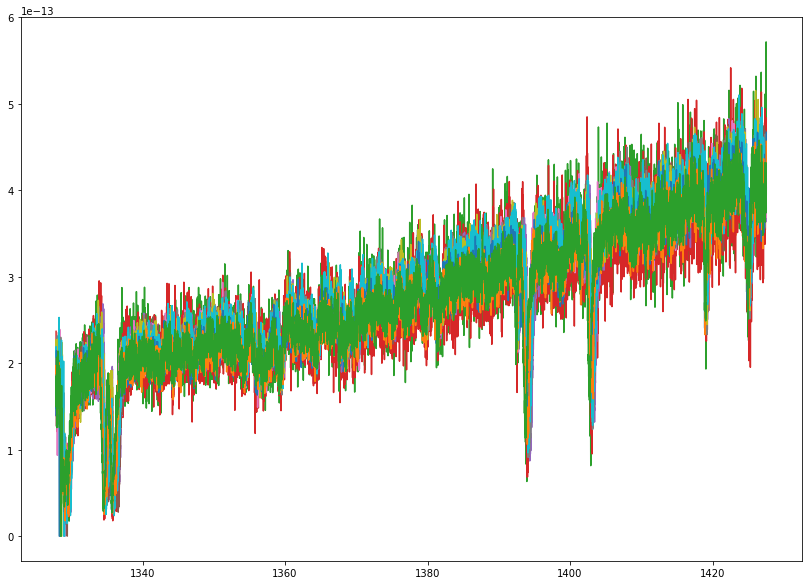

In [4]:
# Plotting the uncorrected spectra 

fig = plt.figure(figsize=(14.0,10.0)) # Making the plot size larger for easier viewing 
for i in range(len(d0)):
    plt.plot(w,d0[i])

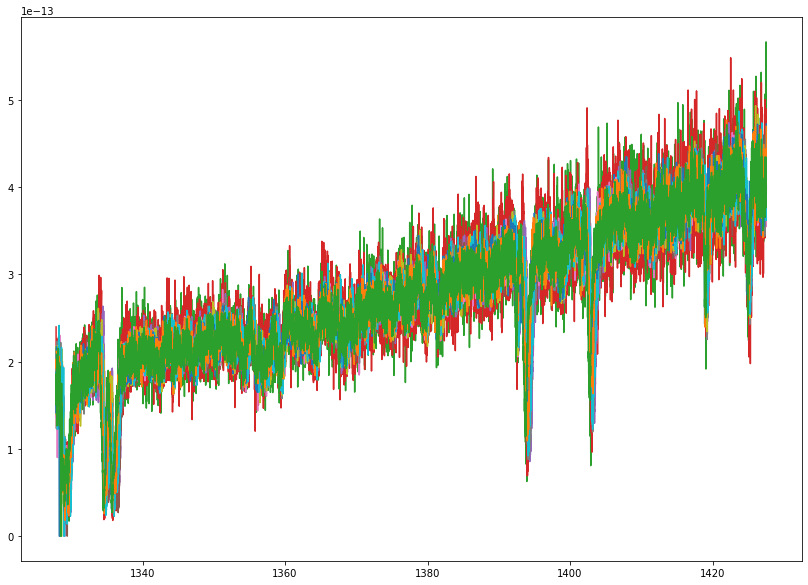

In [5]:
# Plotting the normalised spectra (note the difference in light blue line - shows effect of the normalisation the best)

fig = plt.figure(figsize=(14.0,10.0))
for i in range(len(d0_n)):
   plt.plot(w,d0_n[i])

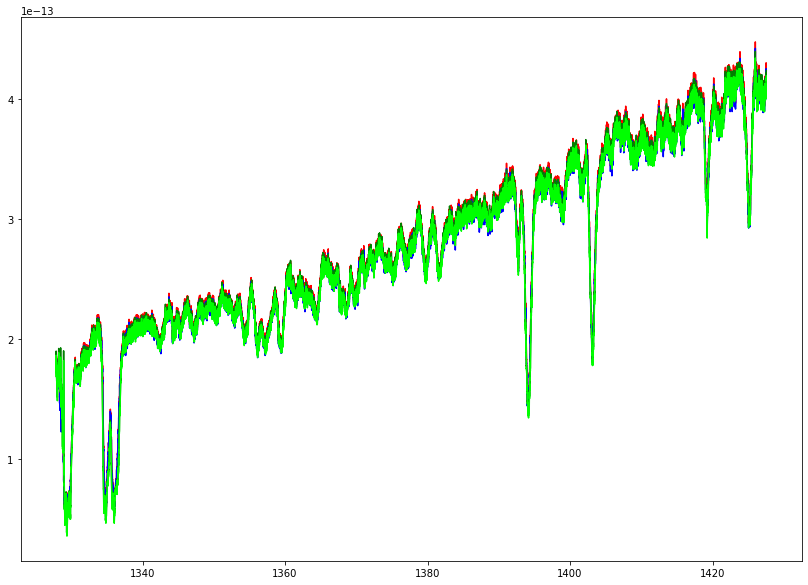

In [6]:
#Plotting the average, the normalised average, the weighted average and normalised weighted average 

fig = plt.figure(figsize=(14.0,10.0))
# Average of the flux over wavelength 
d0_ave = np.average(d0,axis=0)
plt.plot(w ,d0_ave, color = "red")

# Average of normalised flux over wavelength 
d0_n_ave = np.average(d0_n,axis=0)
plt.plot(w, d0_n_ave , color = "blue")

# Weighted average 
d0_w_ave = np.average(d0 , axis = 0 , weights = 1/e0**2) # Using e0 in 1/ as they are stddev and this statistical mean formula
plt.plot(w, d0_w_ave , color = "green")

# Normalised weighted average 
# I think this is correct but will be a talking point - I dont think it matters that the errors have not been normalised
# as they still represent the error from that wavelength and are tied to the exposure time not the flux
d0_n_w_ave = np.average(d0_n , axis = 0 , weights = 1/e0**2)
plt.plot(w, d0_n_w_ave , color = "lime")


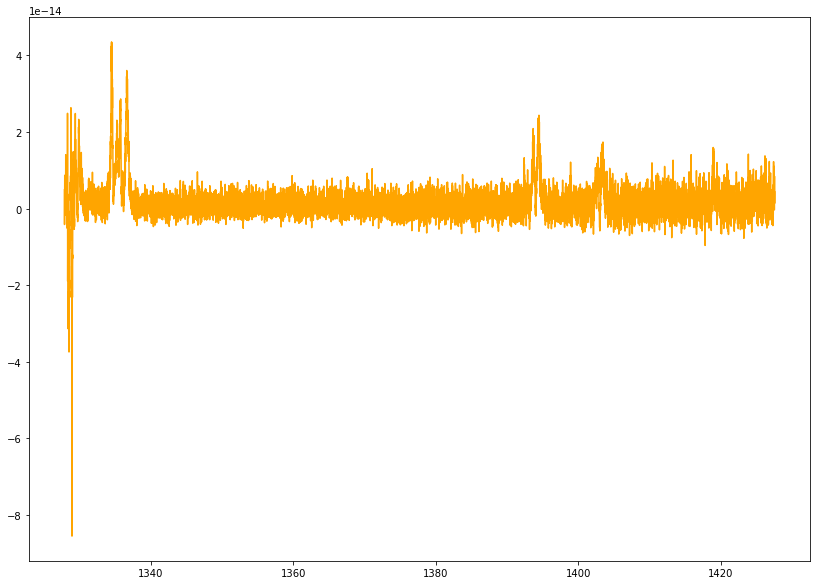

In [7]:
# Showing the points of most discrepancy by plotting the average - the weighted average
fig = plt.figure(figsize=(14.0,10.0))
plt.plot(w , d0_ave-d0_w_ave , color = "orange")


Considering objective 2: alternative average functions. I spent most of Monday changing the functions between average/median/mean and plotting graphs for comparison. Mostly in a futile attempt to find any noticable difference. I have cut most the graphs as it was a lot of the same thing. Graph below was the first one I tried and carried the torch for the rest. The difference between the np.average we were using and the np.mean functions is inconceivable (even when zooming in using the matplotlib widget), I presume this is because in this case the average for the data is almost exactly the true arithmetic mean that np.mean finds (as it is effectivly continous data?), the median does show more variation in every plot however I would like to talk about this - I am not sure if the median is the correct function to use from a statistical/data analysis point of view, however when looking at the plots it appears to have in reigons of instability slightly clearer lines - why is this? 

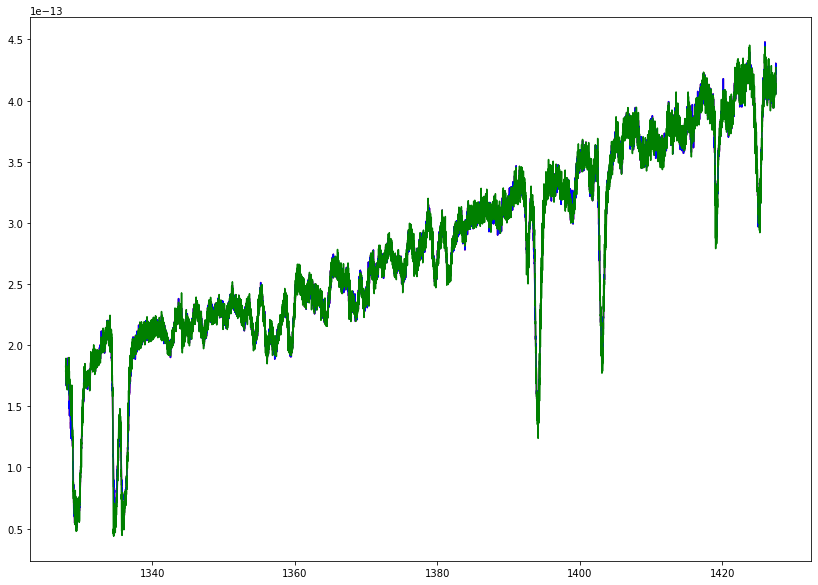

In [8]:
fig = plt.figure(figsize=(14.0,10.0))
# Average of the flux over wavelength 
d0_ave = np.average(d0,axis=0)
plt.plot(w ,d0_ave, color = "red")

d0_ave = np.mean(d0,axis=0)
plt.plot(w ,d0_ave, color = "blue")

d0_ave = np.median(d0,axis=0)
plt.plot(w ,d0_ave, color = "green")




Now looking toward objective 3 - finding a better reigon for weighted averages. From inspection 1340-1390. To do this I will take the w definition and change the x limits, however this is done with the pixel numbers / data points not the wavelength. I thought - I could do this on paper but it is probably worth doing it with code (for transparency and practice). In hindsight I am not sure if I just missed something obvious or if it was just happy coincidence it was almost exaclty 100-1.

In [9]:
#Finding the wavelength range to then find the number of data points per angstrom
w = D[0][0][0][5000:15000]

# Wavelength range
w_range = (w[9999]-w[0])
print(w_range)

# Data points per wavelength 
p_per_w = 10000/w_range
print(p_per_w)

99.65672265750936
100.3444597949206


In [10]:
# Finding the data point range needed to get 1340-1390

LHS_gap_w = (1340-w[0]) #LHS difference in angstroms 
LHS_gap_d = LHS_gap_w*p_per_w # LHS difference in points
LHS_gap_d = round(LHS_gap_d)
print(LHS_gap_d)

RHS_gap_w = (w[9999]-1390) #RHS difference in angstroms 
RHS_gap_d = RHS_gap_w*p_per_w # RHS difference in points
RHS_gap_d = round(RHS_gap_d)
print(RHS_gap_d)

w_LHS = 5000 + LHS_gap_d
w_RHS = 15000 - RHS_gap_d

w = D[0][0][0][w_LHS:w_RHS] #Redefining w with its new boundaries
print(w) 

1217
3766
[1340.00089879 1340.01086546 1340.02083213 ... 1389.97377682 1389.98374349
 1389.99371016]


Now copying from above and editing in the new w. As I have to have it in the data collection section with the .append functions as well as the plots (otherwise the plots dont work as they cannot fit the axes together).

In [11]:
#Allow us to explore the graph in real time (pan, zoom etc).
#%matplotlib widget (the # just to prevent lag when loading every time - I did fix and use this week)

# Creating empty lists for our Flux, Error in Flux, corrected flux values 
d0 = [] # Flux
e0 = [] # Error
d0_n = [] # Corrected flux values

# Extracting the Flux and Flux Error data for each observation and putting them into d0 and e0
for i in range(len(D)): # For each visit (repeat for all 13 data collections)
    for j in range(len(D[i])): # Within each visit (cycle over number of orbits)
        if j == 0: # If orbit == 0 (for the first orbit only - as we are interested in unshifted data)
            d0.append(D[i][j][1][w_LHS:w_RHS]) # Add to d0 the y values (Flux)
            e0.append(D[i][j][2][w_LHS:w_RHS]) # Add to e0 the y error values (Error in Flux)

            
# Converting lists into numpy arrays (allowing for easier manipulation later on with averaging functions)
d0 = np.array(d0)
e0 = np.array(e0)
w = D[0][0][0][w_LHS:w_RHS] # Defining w as the width of the spectra (more simple for plotting and can easily apply boundaries) 



# Normalisation - correcting for different exposure times (exposure time effects Flux, we move all into same frame)
print("The normalisation factors:")
for i in range(len(d0)): # For loop - repeating for each data set 
    factor = np.median(d0[i])/np.median(d0[0]) # Calculating the normalisation factor (how much each spectrum is off from 1st)
    print(factor) # Printing each observations normalisation factor for comparison 
    d0_n.append(d0[i]/factor) # (Spectrum flux values/spectrum normalisation factor), making d0_n corrected flux values 


# Converting list into array - only after using .append 
d0_n = np.array(d0_n)

# Printing median for the each corrected / median for first, to show the factor worked
print("After normalisation discrepancy:")
for i in range(len(d0_n)):
    print(np.median(d0_n[i])/np.median(d0_n[0]))
    
d0_ave = np.average(d0,axis=0)
d0_w_ave = np.average(d0 , axis = 0 , weights = 1/e0**2)

The normalisation factors:
1.0
1.0000864747637255
1.0162090271129227
1.0019560569122834
1.0295723503279985
1.0353199498962302
1.0338764606496083
1.0451334335887275
1.046496056032955
1.051815431673945
0.9901312218087784
0.9703228929543368
0.9930374916890014
After normalisation discrepancy:
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


Plotting the points of most discrepancy again to see that this wavelength range is much more stable than the last. With no extreme peaks from the errors in this reigon.

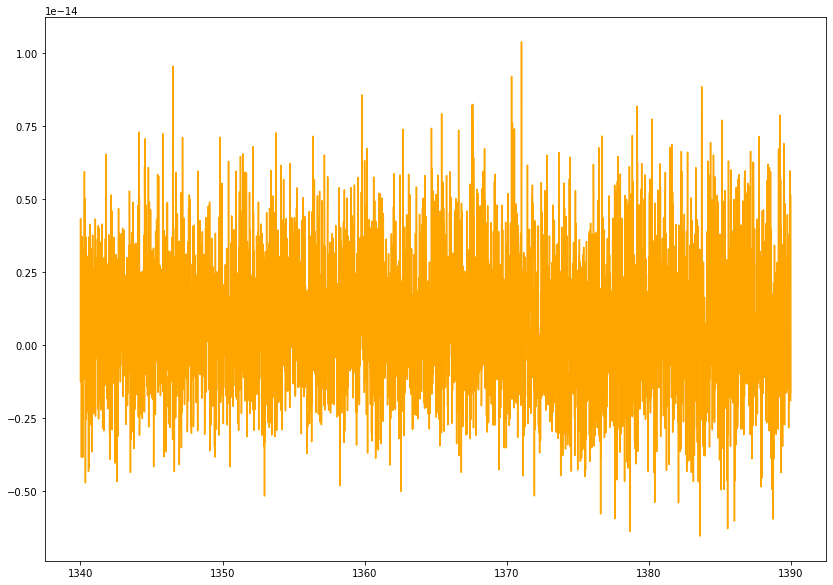

In [12]:
# Showing the points of most discrepancy by plotting the average - the weighted average
fig = plt.figure(figsize=(14.0,10.0))
plt.plot(w , d0_ave-d0_w_ave , color = "orange")


It is easier to see the difference when I plot again but on the same axis scale as the original to show the difference.

(-8.5e-14, 4.5e-14)

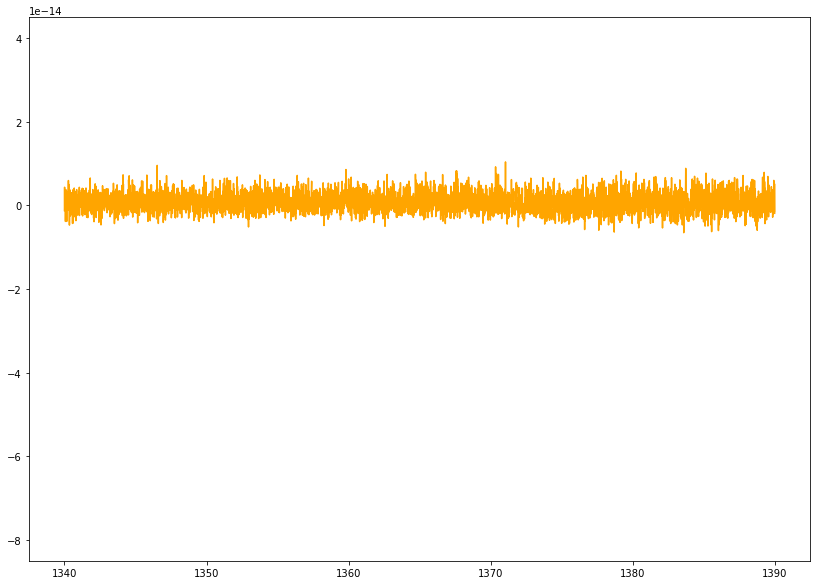

In [13]:
fig = plt.figure(figsize=(14.0,10.0))
plt.plot(w , d0_ave-d0_w_ave , color = "orange")
plt.ylim(-8.5e-14,4.5e-14)

Now using this range, plotting the normalised weighted average.

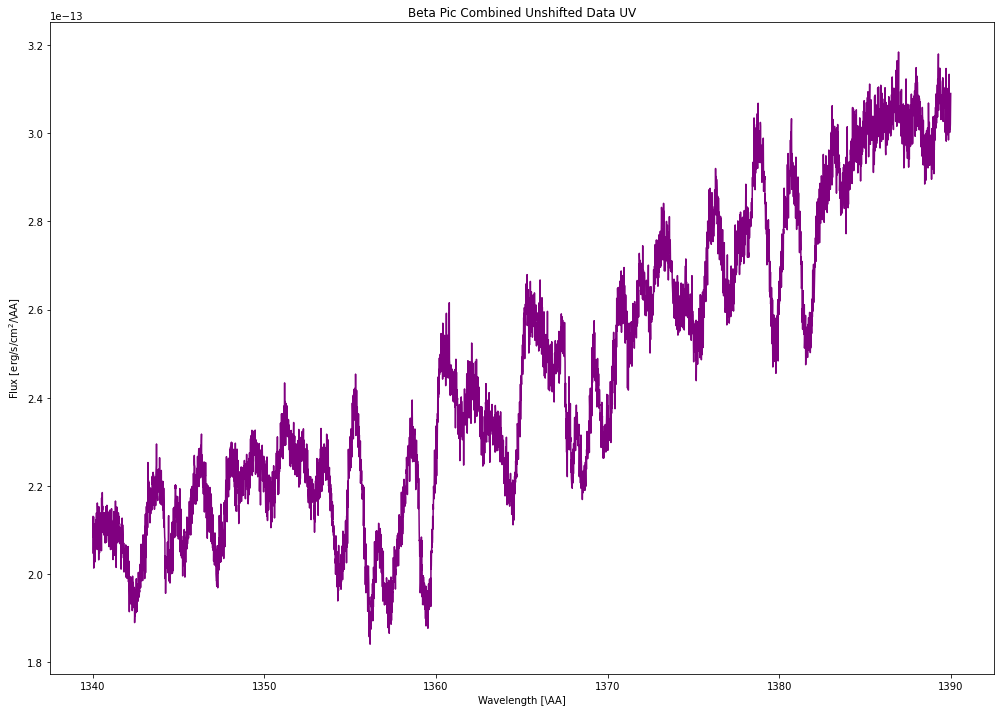

In [14]:
fig = plt.figure(figsize=(14.0,10.0))


# Normalised weighted average 
d0_n_w_ave = np.average(d0_n , axis = 0 , weights = 1/e0**2)
plt.plot(w, d0_n_w_ave , color = "purple")
plt.title("Beta Pic Combined Unshifted Data UV")
plt.xlabel(r'Wavelength [\AA]')
plt.ylabel(r'Flux [erg/s/cm$^2$/\AA]')
fig.tight_layout()


Using the matplotlib widget, it was very interesting to zoom in to this spectrum and see just how many possible absorption lines there are. However as discussed (and leading onto objective 4) they arent quite in the correct place - so no point in measuing their wavelengths. We need to shift the whole spectrum to account for the 20kms Beta Pic is moving away from us. Using the doppler shift equation.

In [15]:
# Doppler Shift Equation from https://www.rpi.edu/dept/phys/observatory/obsastro8.pdf
#(wm - wr)/wr = (v/c)

v = 20 #km/s
vl = 299792458 #m/s
v = v*1000 #m/s


velfactor = v/vl # Defining what I call the velocity factor as when I rearrange the equation we can keep these together
print(velfactor)

wm = w # Measured wavelength / spectrum wavelength
wr = [] # Rest Wavelength / true wavelength 

for i in range(len(wm)): # For all data points in spectrum wavelength
    wr.append(wm[i]/(2*velfactor+2)) # Add to wr wm/2(vf+1) from rearranged equation

wr = wr
print(wm)
print(wr)

6.671281903963041e-05
[1340.00089879 1340.01086546 1340.02083213 ... 1389.97377682 1389.98374349
 1389.99371016]
[669.955754757784, 669.9607377598202, 669.9657207618563, 669.9707037638926, 669.9756867659288, 669.9806697679651, 669.9856527700013, 669.9906357720374, 669.9956187740736, 670.0006017761099, 670.005584778146, 670.0105677801823, 670.0155507822184, 670.0205337842547, 670.025516786291, 670.0304997883271, 670.0354827903634, 670.0404657923995, 670.0454487944357, 670.0504317964719, 670.0554147985082, 670.0603978005444, 670.0653808025805, 670.0703638046167, 670.075346806653, 670.0803298086893, 670.0853128107254, 670.0902958127616, 670.0952788147978, 670.1002618168341, 670.1052448188702, 670.1102278209065, 670.1152108229426, 670.1201938249789, 670.125176827015, 670.1301598290513, 670.1351428310876, 670.1401258331236, 670.1451088351599, 670.1500918371961, 670.1550748392324, 670.1600578412686, 670.1650408433048, 670.1700238453409, 670.1750068473772, 670.1799898494133, 670.1849728514496

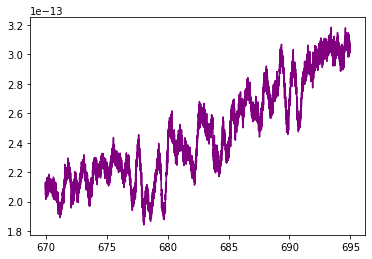

In [16]:
plt.plot(wr, d0_n_w_ave , color = "purple")

In [17]:
print(type(w))

<class 'numpy.ndarray'>


In [18]:
s1, s2 = c.RegionSelect(w, 1350.0, 1360.0)

In [19]:
print(D[0][0][0])

[1278.03811804 1278.0480847  1278.05805137 ... 1481.30134587 1481.31170051
 1481.32205516]


In [20]:
a1, b1, c1 = c.ShiftDATA(D[0][0], 1000, "post")

In [21]:
print(a1)

[1238.03811804 1238.07815808 1238.11819812 ... 1481.30134587 1481.31170051
 1481.32205516]


In [22]:
a2, b2, c2 = c.ShiftDATA(D[0][0], 1, "post")

In [23]:
print(a2)

[1238.03811804 1278.03811804 1278.0480847  ... 1481.30134587 1481.31170051
 1481.32205516]
